# Agent-baseret simulation af et simpelt marked

Først importeres de nødvendige biblioteker:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import marketlib

## Markedsparametre

In [2]:
# Alpha: hvor meget forbrugere vil efterspørge, hvis prisen er nul
alpha = 10.5

# Beta: hældning på demand-kurve, hvor stor effekt prisen på varen har på efterspørgslen
beta = 1.75

# Theta: afgører hvilken indflydelse det har at prisen afviger fra markedsgennemsnittet
theta = 1.45833

# Marginal produktionsomkostninger
c = 8

# Hvor mange tids-skridt skal simuleringen køre?
time_steps = 1000

## Agent parametre

In [3]:
# Hent agent parametre
pe_params, p_params, q_params = marketlib.get_parameters()

# Antal agenter
num_agents = len(pe_params)

# Hvor mange penge har hver agent når simulationen går i gang?
initial_endowment = 500

# Hvilket produktionsniveau starter agenterne på?
initial_production = 7.5

# Hvilken pris sætter agenterne i starten?
initial_price = 11

## Beregning af efterspørgsel

Efterspørgsels-funktionen for markedet

In [4]:
def demand(price, market_price):
    return alpha - beta * price + theta * market_price

## Opret agenterne

In [5]:
def create_agents(n):
    # Tom liste af agenter
    agents = []

    # Opret så mange agenter vi har brug for
    # og gem dem i listen
    for i in range(n):
        agent = marketlib.Producer(initial_price,
                                   initial_production,
                                   initial_endowment,
                                   c = c,
                                   pe = pe_params.iloc[i],
                                   p = p_params.iloc[i],
                                   q = q_params.iloc[i]
                        )
        agents.append(agent)
    return agents

## Beskriv ét trin af simuleringen

In [6]:
def simulation_step(agents, t, mean_prices):
    # Lad agenterne sætte pris og produktionsniveau
    for agent in agents:
        agent.set_price(mean_prices[t-1], mean_prices[t-2])
        agent.set_production_level()

    # Aflæs priser og beregn markedspris
    prices_t = [a.price for a in agents]
    mean_price_t = np.nanmean(prices_t)

    # Lad agenter observere faktisk efterspørgsel
    for agent in agents:
        d = demand(agent.price, mean_price_t)
        agent.observe_demand(d)
        agent.calculate_profit(d)
        agent.update_price_adjustment()

    return prices_t, mean_price_t

## Kør simuleringen
Simpleste måde at køre simuleringen, hvor vi kun gemmer gennemsnitspriserne, og plotter dem.

In [7]:
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_prices[0:3] = initial_price

agents = create_agents(num_agents)

for t in range(3, time_steps):
    # Kør simulering
    prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,0])
    # Gem gennemsnitsprisen
    mean_prices.iloc[t] = mean_price_t

# Vis markedspris over tid

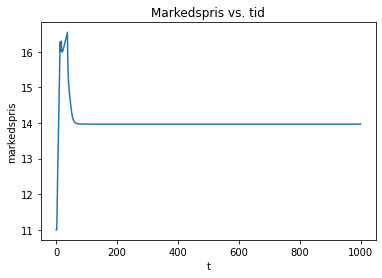

In [8]:
mean_prices.plot(legend = None)
plt.title("Markedspris vs. tid")
plt.xlabel('t')
plt.ylabel('markedspris');

## Kør simuleringen - og gem flere informationer

Kør simuleringen igen, denne gang gemmer vi meget mere information, for at kunne plotte de enkelte agenters opførsel, samt opførslen 

In [9]:
# Opret tabeller til at gemme hver agents pris/produktion/profit, som
# vi kan bruge når vi skal lave grafer
cols = ["agent" + str(i) for i in range(num_agents)]

price_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
quantity_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
profit_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)

mean_productions = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_profits = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_productions[0:3] = initial_production
mean_prices[0:3] = initial_price
mean_profits[0:3] = 0

agents = create_agents(num_agents)
    
for t in range(3, time_steps):
    # Kør simulering
    prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,0])

    # Aflæs produktion og profit fra agenter
    #quantities_t = marketlib.get_attr(agents, "quantity")
    #profits_t = marketlib.get_attr(agents, "profit")
    quantities_t = [a.quantity for a in agents]
    profits_t = [a.profit for a in agents]

    # Beregn gennemsnitlig produktion og profit
    mean_production_t = np.nanmean(quantities_t)
    mean_profit_t = np.nanmean(profits_t)
    
    # Gem agenters profit, priser og produktionsmængder til plots
    profit_df.loc[t] = profits_t
    price_df.loc[t] = prices_t
    quantity_df.loc[t] = quantities_t

    mean_productions.iloc[t] = mean_production_t
    mean_prices.iloc[t] = mean_price_t
    mean_profits.iloc[t] = mean_profit_t
        
    #print(f"{t}: Mean price: {mean_price_t:.2f}  -  Mean production: {mean_production_t:.2f}")

## Plot resultater

Text(0, 0.5, 'profit')

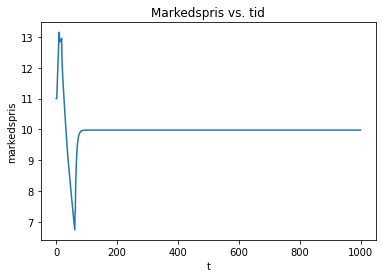

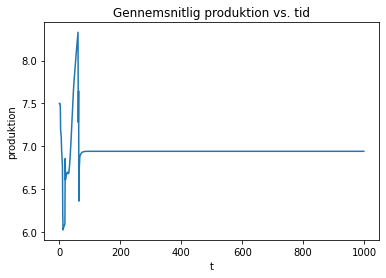

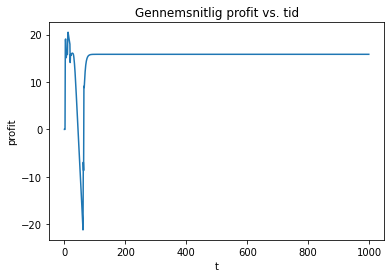

In [10]:
# Markedspris over tid
mean_prices.plot(legend = None)
plt.title("Markedspris vs. tid")
plt.xlabel('t')
plt.ylabel('markedspris')

# Produktion over tid
mean_productions.plot(legend = None)
plt.title('Gennemsnitlig produktion vs. tid')
plt.xlabel('t')
plt.ylabel('produktion')

# Profit over tid
mean_profits.plot(legend = None)
plt.title('Gennemsnitlig profit vs. tid')
plt.xlabel('t')
plt.ylabel('profit')

## Plot kurver for hver enkelt agent

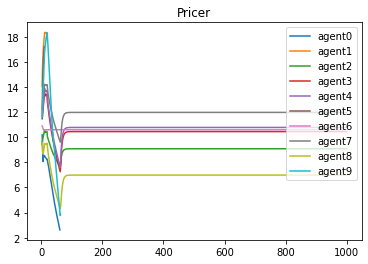

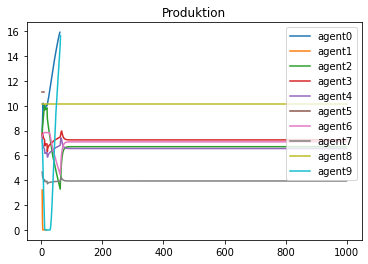

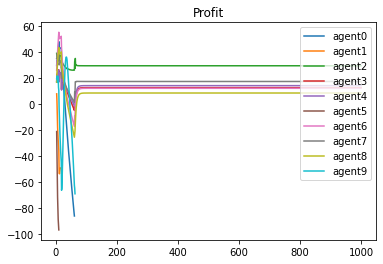

In [11]:
# Visualize how each agent is doing
price_df.plot();
plt.title("Pricer");
plt.legend(loc = "upper right");

quantity_df.plot()
plt.title("Produktion")
plt.legend(loc = "upper right");

profit_df.plot();
plt.title("Profit");
plt.legend(loc = "upper right");

## Gentag simulering

In [12]:
# Antal gentagelser
repetitions = 50

cols = ["r" + str(i) for i in range(repetitions)]
mean_productions = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
mean_profits = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)

mean_productions[0:3] = initial_production
mean_prices[0:3] = initial_price
mean_profits[0:3] = 0

for r in range(repetitions):
    agents = create_agents(num_agents)
    
    for t in range(3, time_steps):
        prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,r])

        # Aflæs produktion og profit fra agenter
        #quantities_t = marketlib.get_attr(agents, "quantity")
        #profits_t = marketlib.get_attr(agents, "profit")
        quantities_t = [a.quantity for a in agents]
        profits_t = [a.profit for a in agents]
    
        # Beregn gennemsnitlig produktion og profit
        mean_production_t = np.nanmean(quantities_t)
        mean_profit_t = np.nanmean(profits_t)
        
        # Gem data til plots
        mean_productions.iloc[t,r] = mean_production_t
        mean_prices.iloc[t,r] = mean_price_t
        mean_profits.iloc[t,r] = mean_profit_t
        
    print(f"{r}:   Mean price: {mean_price_t:.2f}  -  Mean production: {mean_production_t:.2f}")

0:   Mean price: 9.45  -  Mean production: 7.34
1:   Mean price: 10.93  -  Mean production: 6.28
2:   Mean price: 11.25  -  Mean production: 5.69
3:   Mean price: 12.32  -  Mean production: 6.99
4:   Mean price: 9.71  -  Mean production: 6.03
5:   Mean price: 11.60  -  Mean production: 7.49
6:   Mean price: 10.19  -  Mean production: 6.33
7:   Mean price: 11.13  -  Mean production: 6.75
8:   Mean price: 9.96  -  Mean production: 6.16
9:   Mean price: 12.37  -  Mean production: 6.14
10:   Mean price: 10.54  -  Mean production: 6.68
11:   Mean price: 11.61  -  Mean production: 6.17
12:   Mean price: 11.79  -  Mean production: 6.39
13:   Mean price: 10.05  -  Mean production: 7.83
14:   Mean price: 10.32  -  Mean production: 5.90
15:   Mean price: 11.85  -  Mean production: 6.41
16:   Mean price: 11.05  -  Mean production: 6.82
17:   Mean price: 9.83  -  Mean production: 6.57
18:   Mean price: 10.96  -  Mean production: 6.45
19:   Mean price: 10.61  -  Mean production: 5.95
20:   Mean pri

<AxesSubplot:>

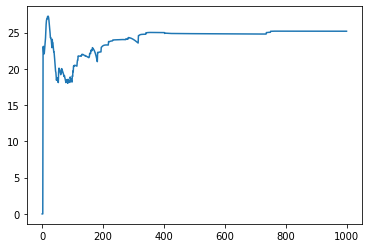

In [13]:
mean_profits.mean(1).plot()

<AxesSubplot:>

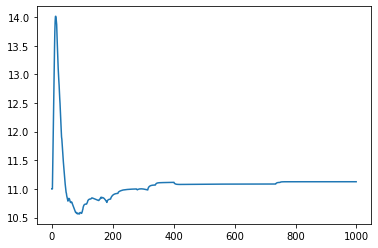

In [14]:
mean_prices.mean(1).plot()

<AxesSubplot:>

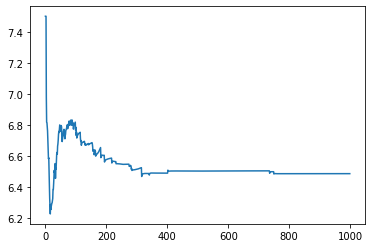

In [15]:
mean_productions.mean(1).plot()

statistics = mean_prices.agg(['mean', 'count', 'std'], axis=1)
print(statistics)
print('-'*30)

ci95_hi = []
ci95_lo = []

for i in statistics.index:
    m, c, s = statistics.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

statistics['ci95_hi'] = ci95_hi
statistics['ci95_lo'] = ci95_lo
statistics.loc[:,["ci95_hi", "mean", "ci95_lo"]].plot()